In [3]:
%cd ../PixArt-alpha

/n/home12/binxuwang/Github/DiffusionObjectRelation/PixArt-alpha


In [33]:
!python tools/convert_pixart_alpha_to_diffusers.py \
    --orig_ckpt_path ${STORE_DIR}"/DL_Projects/PixArt/results/objrel_pilot/output/trained_model/checkpoints/epoch_350_step_14000.pth" \
    --dump_path ${STORE_DIR}"/DL_Projects/PixArt/results/objrel_pilot/output/diffusers_trained" \
    --only_transformer=True \
    --image_size 128 \
    --multi_scale_train=False \
    --model_name "DiT_S-2"


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
Total number of transformer parameters: 31273376


In [35]:
!ls ${STORE_DIR}"/DL_Projects/PixArt/results/objrel_pilot/output/diffusers_trained"/transformer

config.json  diffusion_pytorch_model.safetensors


In [ ]:
from os.path import join
import torch
from diffusers import Transformer2DModel
from diffusers import PixArtAlphaPipeline

In [45]:
import os
import torch
from diffusers import Transformer2DModel

config_dict = {
    "DiT_S-2": {"num_layers": 12, "attention_head_dim": 64, "in_channels": 4, "out_channels": 8, "patch_size": 2, "num_attention_heads": 6, "cross_attention_dim": 384},
    "DiT_B-2": {"num_layers": 12, "attention_head_dim": 64, "in_channels": 4, "out_channels": 8, "patch_size": 2, "num_attention_heads": 12, "cross_attention_dim": 768},
    "DiT_L-2": {"num_layers": 24, "attention_head_dim": 64, "in_channels": 4, "out_channels": 8, "patch_size": 2, "num_attention_heads": 12, "cross_attention_dim": 768},
    "DiT_XL-2": {"num_layers": 28, "attention_head_dim": 72, "in_channels": 4, "out_channels": 8, "patch_size": 2, "num_attention_heads": 16, "cross_attention_dim": 1152},
}

def convert_checkpoint_to_diffusers_transformer(orig_ckpt_path, dump_path=None, model_name="DiT_XL-2", image_size=128, multi_scale_train=False, config=None):
    if model_name not in config_dict and config is None:
        raise ValueError(f"Model name {model_name} not supported")
    if config is None:
        config = config_dict[model_name]
    else:
        config = config
    all_state_dict = torch.load(orig_ckpt_path, map_location='cpu')
    state_dict = all_state_dict.pop("state_dict")
    converted_state_dict = {}

    # Patch embeddings.
    converted_state_dict["pos_embed.proj.weight"] = state_dict.pop("x_embedder.proj.weight")
    converted_state_dict["pos_embed.proj.bias"] = state_dict.pop("x_embedder.proj.bias")

    # Caption projection.
    converted_state_dict["caption_projection.linear_1.weight"] = state_dict.pop("y_embedder.y_proj.fc1.weight")
    converted_state_dict["caption_projection.linear_1.bias"] = state_dict.pop("y_embedder.y_proj.fc1.bias")
    converted_state_dict["caption_projection.linear_2.weight"] = state_dict.pop("y_embedder.y_proj.fc2.weight")
    converted_state_dict["caption_projection.linear_2.bias"] = state_dict.pop("y_embedder.y_proj.fc2.bias")

    # AdaLN-single LN
    converted_state_dict["adaln_single.emb.timestep_embedder.linear_1.weight"] = state_dict.pop(
        "t_embedder.mlp.0.weight"
    )
    converted_state_dict["adaln_single.emb.timestep_embedder.linear_1.bias"] = state_dict.pop("t_embedder.mlp.0.bias")
    converted_state_dict["adaln_single.emb.timestep_embedder.linear_2.weight"] = state_dict.pop(
        "t_embedder.mlp.2.weight"
    )
    converted_state_dict["adaln_single.emb.timestep_embedder.linear_2.bias"] = state_dict.pop("t_embedder.mlp.2.bias")

    if image_size == 1024 and multi_scale_train:
        # Resolution.
        converted_state_dict["adaln_single.emb.resolution_embedder.linear_1.weight"] = state_dict.pop(
            "csize_embedder.mlp.0.weight"
        )
        converted_state_dict["adaln_single.emb.resolution_embedder.linear_1.bias"] = state_dict.pop(
            "csize_embedder.mlp.0.bias"
        )
        converted_state_dict["adaln_single.emb.resolution_embedder.linear_2.weight"] = state_dict.pop(
            "csize_embedder.mlp.2.weight"
        )
        converted_state_dict["adaln_single.emb.resolution_embedder.linear_2.bias"] = state_dict.pop(
            "csize_embedder.mlp.2.bias"
        )
        # Aspect ratio.
        converted_state_dict["adaln_single.emb.aspect_ratio_embedder.linear_1.weight"] = state_dict.pop(
            "ar_embedder.mlp.0.weight"
        )
        converted_state_dict["adaln_single.emb.aspect_ratio_embedder.linear_1.bias"] = state_dict.pop(
            "ar_embedder.mlp.0.bias"
        )
        converted_state_dict["adaln_single.emb.aspect_ratio_embedder.linear_2.weight"] = state_dict.pop(
            "ar_embedder.mlp.2.weight"
        )
        converted_state_dict["adaln_single.emb.aspect_ratio_embedder.linear_2.bias"] = state_dict.pop(
            "ar_embedder.mlp.2.bias"
        )
    # Shared norm.
    converted_state_dict["adaln_single.linear.weight"] = state_dict.pop("t_block.1.weight")
    converted_state_dict["adaln_single.linear.bias"] = state_dict.pop("t_block.1.bias")

    for depth in range(config["num_layers"]):
        # Transformer blocks.
        converted_state_dict[f"transformer_blocks.{depth}.scale_shift_table"] = state_dict.pop(
            f"blocks.{depth}.scale_shift_table"
        )

        # Attention is all you need 🤘

        # Self attention.
        q, k, v = torch.chunk(state_dict.pop(f"blocks.{depth}.attn.qkv.weight"), 3, dim=0)
        q_bias, k_bias, v_bias = torch.chunk(state_dict.pop(f"blocks.{depth}.attn.qkv.bias"), 3, dim=0)
        converted_state_dict[f"transformer_blocks.{depth}.attn1.to_q.weight"] = q
        converted_state_dict[f"transformer_blocks.{depth}.attn1.to_q.bias"] = q_bias
        converted_state_dict[f"transformer_blocks.{depth}.attn1.to_k.weight"] = k
        converted_state_dict[f"transformer_blocks.{depth}.attn1.to_k.bias"] = k_bias
        converted_state_dict[f"transformer_blocks.{depth}.attn1.to_v.weight"] = v
        converted_state_dict[f"transformer_blocks.{depth}.attn1.to_v.bias"] = v_bias
        # Projection.
        converted_state_dict[f"transformer_blocks.{depth}.attn1.to_out.0.weight"] = state_dict.pop(
            f"blocks.{depth}.attn.proj.weight"
        )
        converted_state_dict[f"transformer_blocks.{depth}.attn1.to_out.0.bias"] = state_dict.pop(
            f"blocks.{depth}.attn.proj.bias"
        )

        # Feed-forward.
        converted_state_dict[f"transformer_blocks.{depth}.ff.net.0.proj.weight"] = state_dict.pop(
            f"blocks.{depth}.mlp.fc1.weight"
        )
        converted_state_dict[f"transformer_blocks.{depth}.ff.net.0.proj.bias"] = state_dict.pop(
            f"blocks.{depth}.mlp.fc1.bias"
        )
        converted_state_dict[f"transformer_blocks.{depth}.ff.net.2.weight"] = state_dict.pop(
            f"blocks.{depth}.mlp.fc2.weight"
        )
        converted_state_dict[f"transformer_blocks.{depth}.ff.net.2.bias"] = state_dict.pop(
            f"blocks.{depth}.mlp.fc2.bias"
        )

        # Cross-attention.
        q = state_dict.pop(f"blocks.{depth}.cross_attn.q_linear.weight")
        q_bias = state_dict.pop(f"blocks.{depth}.cross_attn.q_linear.bias")
        k, v = torch.chunk(state_dict.pop(f"blocks.{depth}.cross_attn.kv_linear.weight"), 2, dim=0)
        k_bias, v_bias = torch.chunk(state_dict.pop(f"blocks.{depth}.cross_attn.kv_linear.bias"), 2, dim=0)

        converted_state_dict[f"transformer_blocks.{depth}.attn2.to_q.weight"] = q
        converted_state_dict[f"transformer_blocks.{depth}.attn2.to_q.bias"] = q_bias
        converted_state_dict[f"transformer_blocks.{depth}.attn2.to_k.weight"] = k
        converted_state_dict[f"transformer_blocks.{depth}.attn2.to_k.bias"] = k_bias
        converted_state_dict[f"transformer_blocks.{depth}.attn2.to_v.weight"] = v
        converted_state_dict[f"transformer_blocks.{depth}.attn2.to_v.bias"] = v_bias

        converted_state_dict[f"transformer_blocks.{depth}.attn2.to_out.0.weight"] = state_dict.pop(
            f"blocks.{depth}.cross_attn.proj.weight"
        )
        converted_state_dict[f"transformer_blocks.{depth}.attn2.to_out.0.bias"] = state_dict.pop(
            f"blocks.{depth}.cross_attn.proj.bias"
        )

    # Final block.
    converted_state_dict["proj_out.weight"] = state_dict.pop("final_layer.linear.weight")
    converted_state_dict["proj_out.bias"] = state_dict.pop("final_layer.linear.bias")
    converted_state_dict["scale_shift_table"] = state_dict.pop("final_layer.scale_shift_table")

    # DiT XL/2
    transformer = Transformer2DModel(
        sample_size=image_size // 8,
        num_layers=config["num_layers"],
        attention_head_dim=config["attention_head_dim"],
        in_channels=4,
        out_channels=8,
        patch_size=config["patch_size"],
        attention_bias=True,
        num_attention_heads=config["num_attention_heads"],
        cross_attention_dim=config["cross_attention_dim"],
        activation_fn="gelu-approximate",
        num_embeds_ada_norm=1000,
        norm_type="ada_norm_single",
        norm_elementwise_affine=False,
        norm_eps=1e-6,
        caption_channels=4096,
    )
    transformer.load_state_dict(converted_state_dict, strict=True)

    assert transformer.pos_embed.pos_embed is not None
    state_dict.pop("pos_embed")
    state_dict.pop("y_embedder.y_embedding")
    assert len(state_dict) == 0, f"State dict is not empty, {state_dict.keys()}"

    num_model_params = sum(p.numel() for p in transformer.parameters())
    print(f"Total number of transformer parameters: {num_model_params}")
    if dump_path:
        transformer.save_pretrained(os.path.join(dump_path, "transformer"))
    return transformer

In [ ]:
import math
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.utils as vutils

def pil_images_to_grid(
    images,
    grid_size=None,
    image_size=None,
    padding=2,
    normalize=False,
    background_color=(255, 255, 255)
):
    """
    Arrange a list of PIL Images into a grid and return the grid as a PIL Image.

    :param images: List of PIL.Image objects.
    :param grid_size: Tuple (columns, rows). If None, grid size is calculated to be as square as possible.
    :param image_size: Tuple (width, height). If provided, images will be resized to this size.
    :param padding: Padding between images in pixels.
    :param normalize: Whether to normalize the images.
    :param background_color: Background color tuple, e.g., (255, 255, 255) for white.
    :return: A PIL.Image object representing the grid.
    """
    if not images:
        raise ValueError("The images list is empty.")

    num_images = len(images)

    # Determine grid size
    if grid_size:
        cols, rows = grid_size
    else:
        cols = math.ceil(math.sqrt(num_images))
        rows = math.ceil(num_images / cols)

    # Define transformation: resize and convert to tensor
    transform_list = []
    if image_size:
        transform_list.append(transforms.Resize(image_size))
    transform_list.append(transforms.ToTensor())  # Converts to [0,1] range
    transform = transforms.Compose(transform_list)

    # Apply transformations
    transformed_images = []
    for img in images:
        img = img.convert('RGB')  # Ensure all images have 3 channels
        img = transform(img)
        transformed_images.append(img)

    # Stack images into a single tensor
    batch_tensor = torch.stack(transformed_images)  # Shape: (B, C, H, W)

    # Create grid using torchvision
    grid_tensor = vutils.make_grid(
        batch_tensor,
        nrow=cols,
        padding=padding,
        normalize=normalize,
        pad_value=0  # Will set background color later
    )

    # Convert grid tensor to PIL Image
    # If normalize is True, make_grid scales the tensor to [0,1], else [0,1] assuming input was [0,1]
    to_pil = transforms.ToPILImage()
    grid_image = to_pil(grid_tensor)

    # If padding is set and background_color is not white, adjust the padding
    if padding > 0 and background_color != (0, 0, 0):
        # Create a new image with the desired background color
        grid_width, grid_height = grid_image.size
        bg = Image.new('RGB', grid_image.size, background_color)
        bg.paste(grid_image, mask=grid_image.split()[3] if grid_image.mode == 'RGBA' else None)
        grid_image = bg

    return grid_image

In [46]:
!echo ${STORE_DIR}"/DL_Projects/PixArt/results/objrel_pilot/output/trained_model/checkpoints"

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_pilot/output/trained_model/checkpoints


In [69]:
ckpt_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_pilot/output/trained_model/checkpoints"
# find the latest checkpoint
ckpt_files = os.listdir(ckpt_root)
ckpt_files = [f for f in ckpt_files if f.startswith("epoch") and f.endswith(".pth")]
ckpt_files.sort()
ckpt_files

['epoch_100_step_4000.pth',
 'epoch_125_step_5000.pth',
 'epoch_150_step_6000.pth',
 'epoch_175_step_7000.pth',
 'epoch_200_step_8000.pth',
 'epoch_225_step_9000.pth',
 'epoch_250_step_10000.pth',
 'epoch_25_step_1000.pth',
 'epoch_275_step_11000.pth',
 'epoch_300_step_12000.pth',
 'epoch_325_step_13000.pth',
 'epoch_350_step_14000.pth',
 'epoch_375_step_15000.pth',
 'epoch_400_step_16000.pth',
 'epoch_425_step_17000.pth',
 'epoch_450_step_18000.pth',
 'epoch_475_step_19000.pth',
 'epoch_500_step_20000.pth',
 'epoch_50_step_2000.pth',
 'epoch_525_step_21000.pth',
 'epoch_550_step_22000.pth',
 'epoch_575_step_23000.pth',
 'epoch_600_step_24000.pth',
 'epoch_625_step_25000.pth',
 'epoch_650_step_26000.pth',
 'epoch_675_step_27000.pth',
 'epoch_75_step_3000.pth']

In [70]:
ckpt_files

['epoch_100_step_4000.pth',
 'epoch_125_step_5000.pth',
 'epoch_150_step_6000.pth',
 'epoch_175_step_7000.pth',
 'epoch_200_step_8000.pth',
 'epoch_225_step_9000.pth',
 'epoch_250_step_10000.pth',
 'epoch_25_step_1000.pth',
 'epoch_275_step_11000.pth',
 'epoch_300_step_12000.pth',
 'epoch_325_step_13000.pth',
 'epoch_350_step_14000.pth',
 'epoch_375_step_15000.pth',
 'epoch_400_step_16000.pth',
 'epoch_425_step_17000.pth',
 'epoch_450_step_18000.pth',
 'epoch_475_step_19000.pth',
 'epoch_500_step_20000.pth',
 'epoch_50_step_2000.pth',
 'epoch_525_step_21000.pth',
 'epoch_550_step_22000.pth',
 'epoch_575_step_23000.pth',
 'epoch_600_step_24000.pth',
 'epoch_625_step_25000.pth',
 'epoch_650_step_26000.pth',
 'epoch_675_step_27000.pth',
 'epoch_75_step_3000.pth']

In [71]:
latest_ckpt = 'epoch_675_step_27000.pth'
transformer = convert_checkpoint_to_diffusers_transformer(join(ckpt_root, latest_ckpt) , None, "DiT_S-2", 128,)

Total number of transformer parameters: 31273376


In [36]:
transformer = Transformer2DModel.from_pretrained("/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_pilot/output/diffusers_trained/transformer", 
                                                 torch_dtype=torch.float16)

In [37]:
pipe = PixArtAlphaPipeline.from_pretrained("PixArt-alpha/PixArt-XL-2-512x512", torch_dtype=torch.float16, transformer=transformer)
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

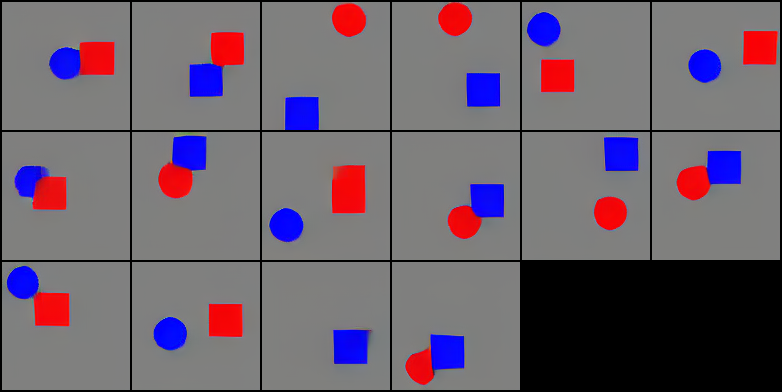

In [43]:
prompt = "red circle on the left of blue square"
images = pipe(prompt=prompt, use_resolution_binning=False, num_images_per_prompt=16).images # height=128, width=128, 
# make grid out of images
images[0]
pil_images_to_grid(images, grid_size=(6, 3))

In [72]:
latest_ckpt = 'epoch_675_step_27000.pth'
transformer = convert_checkpoint_to_diffusers_transformer(join(ckpt_root, latest_ckpt) , None, "DiT_S-2", 128,)
pipe = PixArtAlphaPipeline.from_pretrained("PixArt-alpha/PixArt-XL-2-512x512", torch_dtype=torch.float16, transformer=transformer.half())
pipe = pipe.to("cuda")

Total number of transformer parameters: 31273376


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

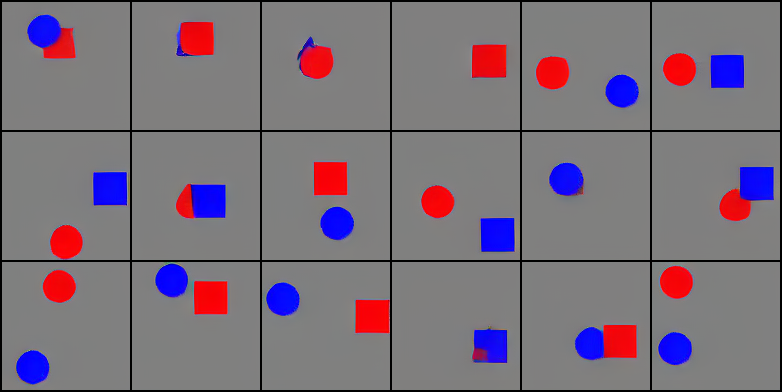

In [73]:
prompt = "red circle on the left of blue square"
images = pipe(prompt=prompt, use_resolution_binning=False, 
              num_images_per_prompt=18, guidance_scale=1).images # height=128, width=128, 
pil_images_to_grid(images, grid_size=(6, 3))
# images[0]

In [ ]:
from IPython.display import Image, display

In [75]:
import re
def extract_epoch_step(filename):
    match = re.match(r'epoch_(\d+)_step_(\d+)\.pth', filename)
    if match:
        epoch = int(match.group(1))
        step = int(match.group(2))
        return (epoch, step)
    else:
        return (0, 0)  # Default values if pattern doesn't match

# Sort the list using the extracted numbers
sorted_filenames = sorted(ckpt_files, key=extract_epoch_step)

In [ ]:
pipe = PixArtAlphaPipeline.from_pretrained("PixArt-alpha/PixArt-XL-2-512x512", torch_dtype=torch.float16, transformer=transformer.half())
pipe = pipe.to("cuda")

Epoch: 25, Step: 1000
Total number of transformer parameters: 31273376


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 25, Step: 1000


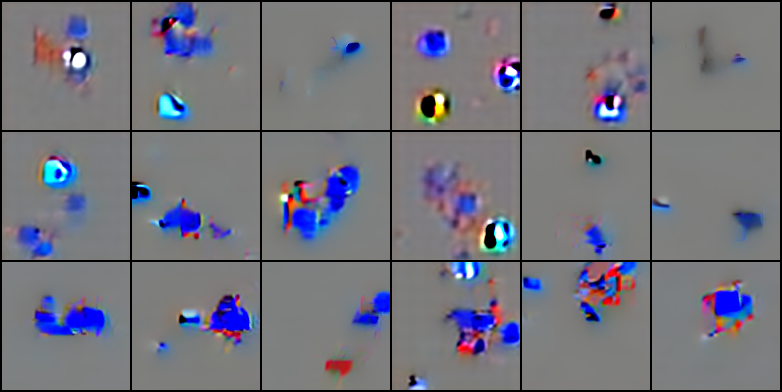

Epoch: 50, Step: 2000
Total number of transformer parameters: 31273376


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 50, Step: 2000


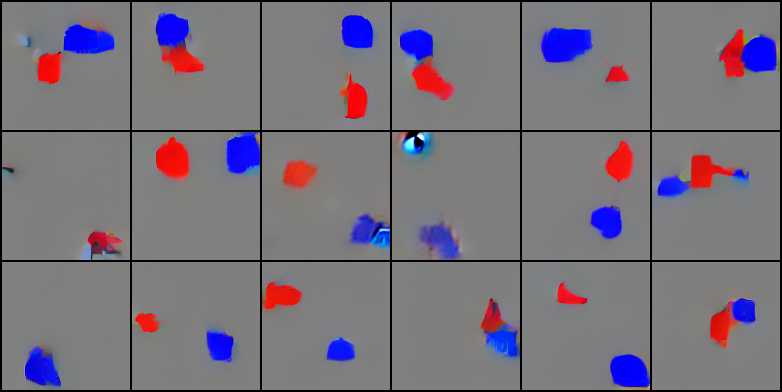

Epoch: 75, Step: 3000
Total number of transformer parameters: 31273376


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 75, Step: 3000


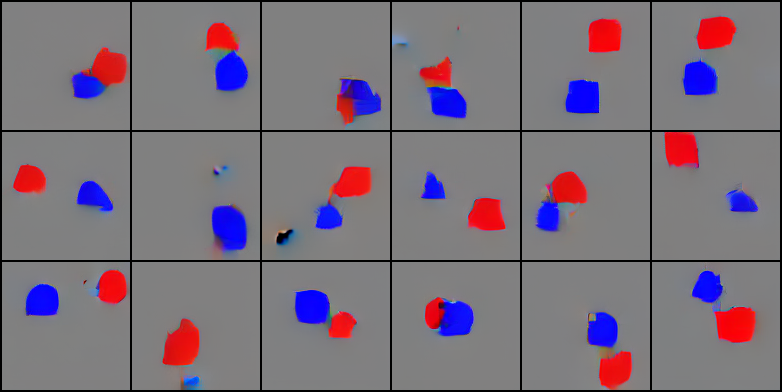

Epoch: 100, Step: 4000
Total number of transformer parameters: 31273376


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 100, Step: 4000


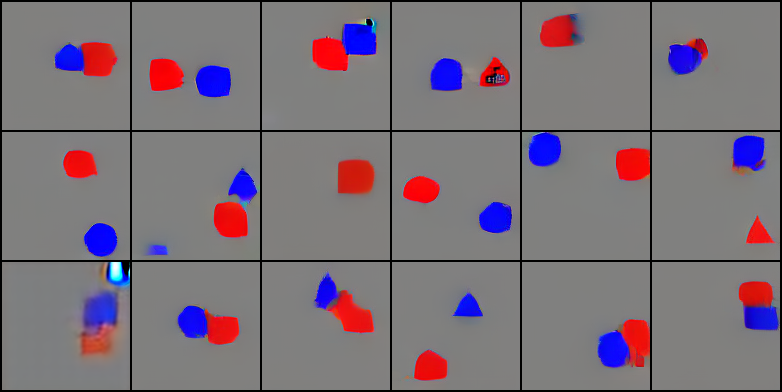

Epoch: 125, Step: 5000
Total number of transformer parameters: 31273376


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 125, Step: 5000


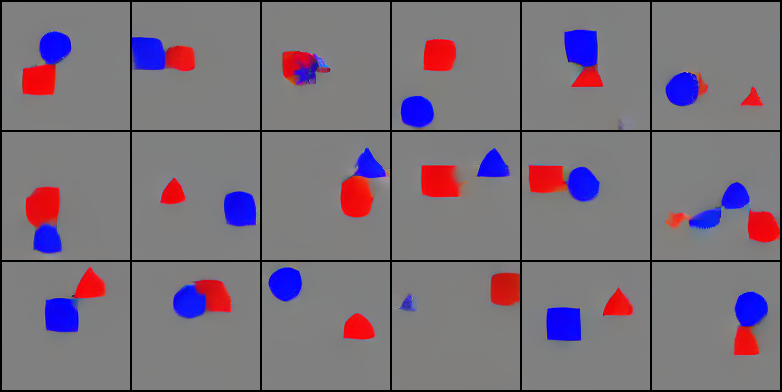

Epoch: 150, Step: 6000
Total number of transformer parameters: 31273376


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 150, Step: 6000


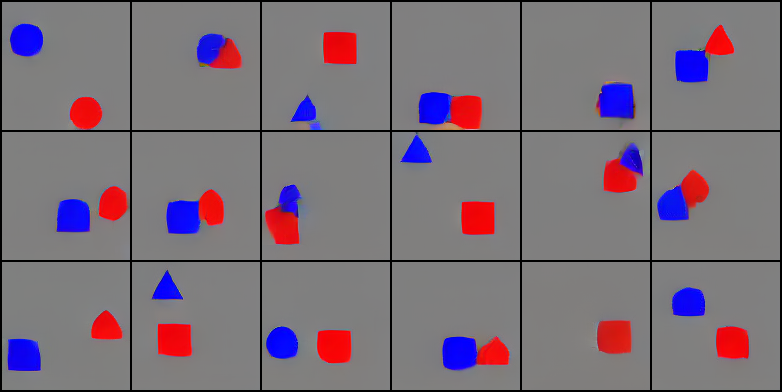

Epoch: 175, Step: 7000
Total number of transformer parameters: 31273376


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 175, Step: 7000


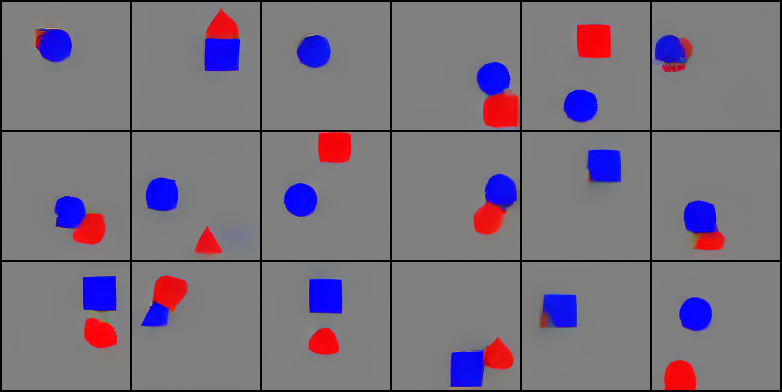

Epoch: 200, Step: 8000
Total number of transformer parameters: 31273376


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 200, Step: 8000


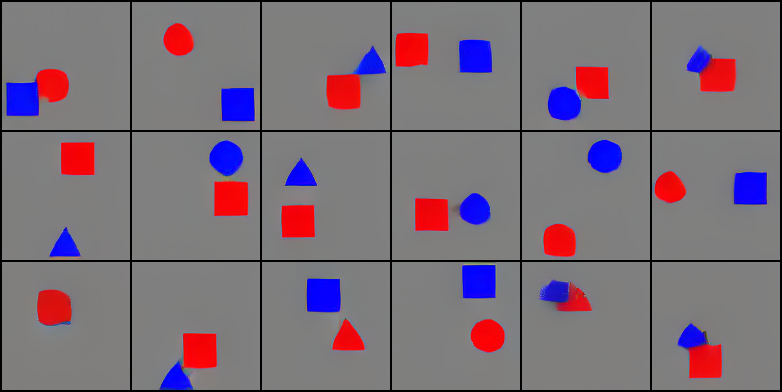

Epoch: 225, Step: 9000
Total number of transformer parameters: 31273376


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 225, Step: 9000


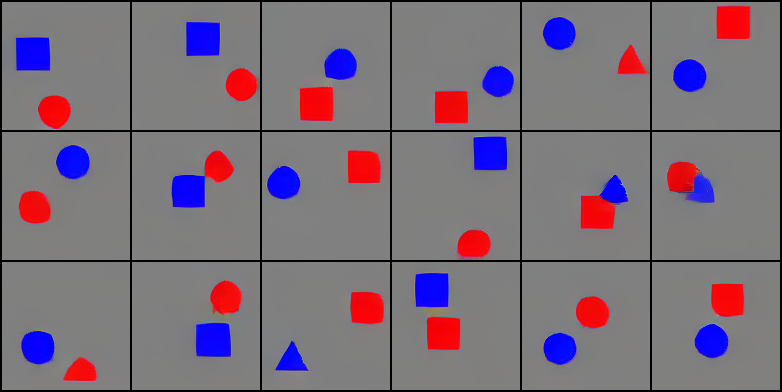

Epoch: 250, Step: 10000
Total number of transformer parameters: 31273376


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 250, Step: 10000


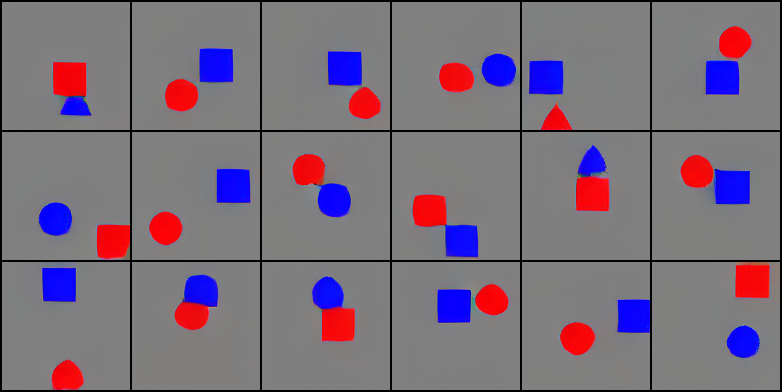

Epoch: 275, Step: 11000
Total number of transformer parameters: 31273376


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 275, Step: 11000


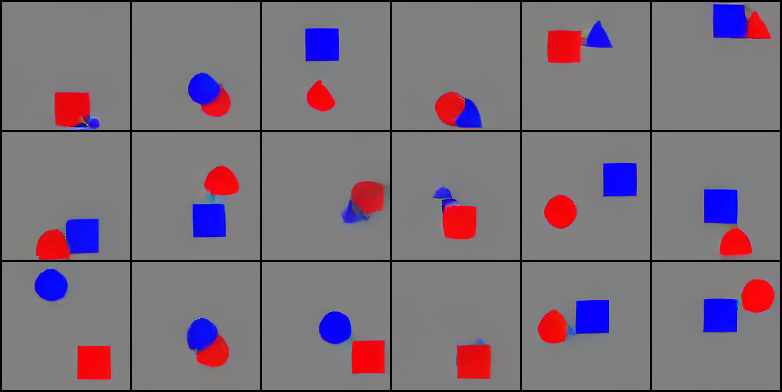

Epoch: 300, Step: 12000
Total number of transformer parameters: 31273376


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 300, Step: 12000


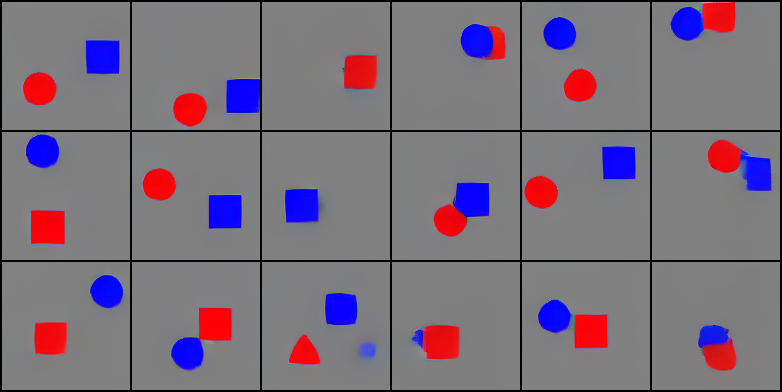

Epoch: 325, Step: 13000
Total number of transformer parameters: 31273376


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 325, Step: 13000


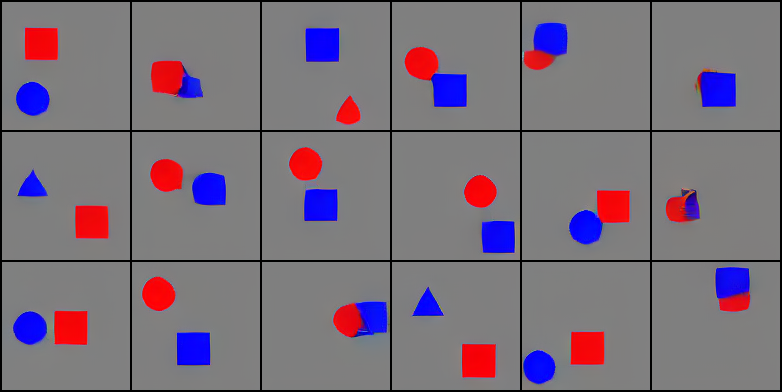

Epoch: 350, Step: 14000
Total number of transformer parameters: 31273376


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 350, Step: 14000


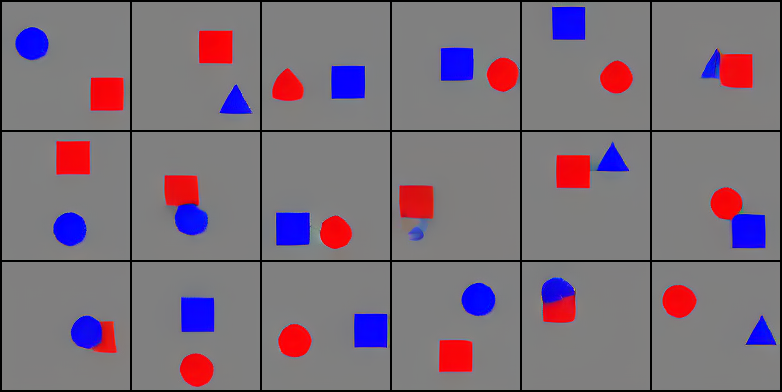

Epoch: 375, Step: 15000
Total number of transformer parameters: 31273376


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 375, Step: 15000


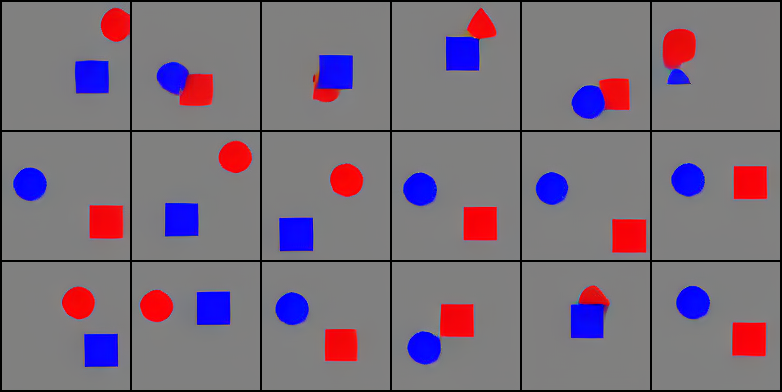

Epoch: 400, Step: 16000
Total number of transformer parameters: 31273376


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 400, Step: 16000


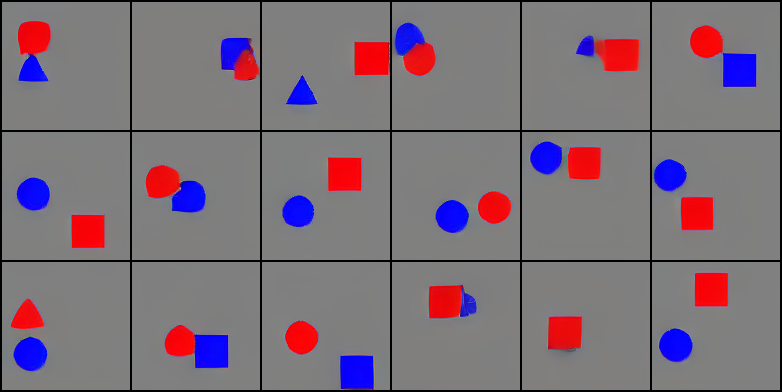

Epoch: 425, Step: 17000
Total number of transformer parameters: 31273376


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 425, Step: 17000


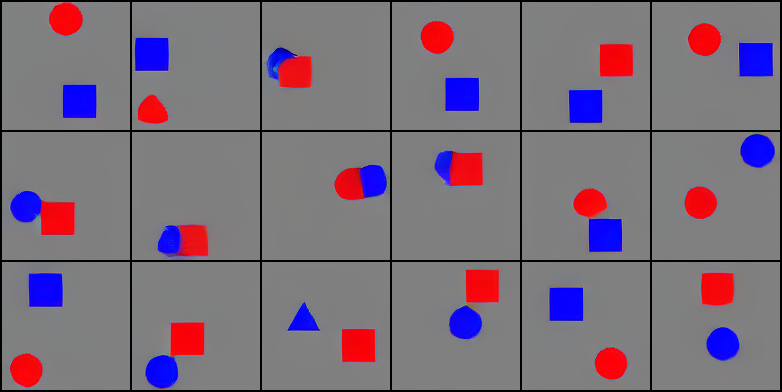

Epoch: 450, Step: 18000
Total number of transformer parameters: 31273376


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 450, Step: 18000


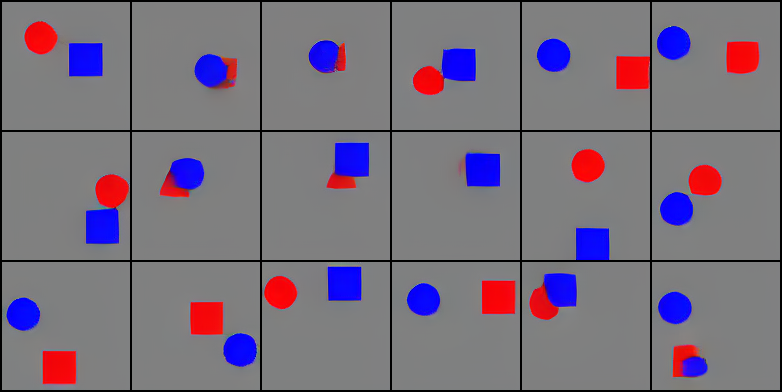

Epoch: 475, Step: 19000
Total number of transformer parameters: 31273376


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 475, Step: 19000


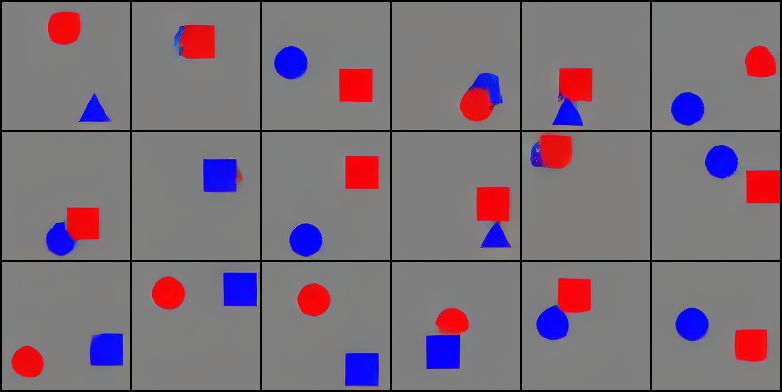

Epoch: 500, Step: 20000
Total number of transformer parameters: 31273376


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 500, Step: 20000


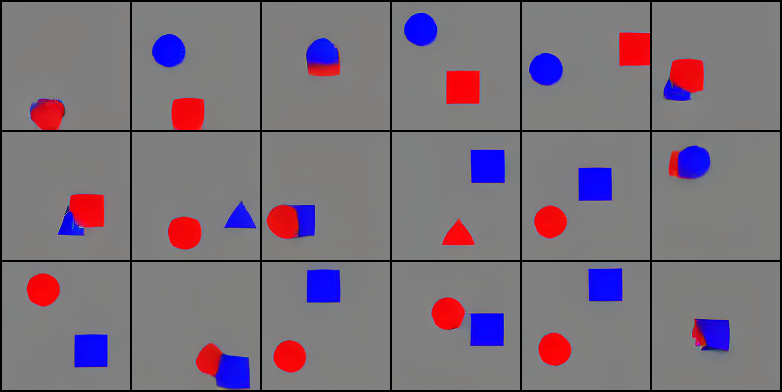

Epoch: 525, Step: 21000
Total number of transformer parameters: 31273376


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 525, Step: 21000


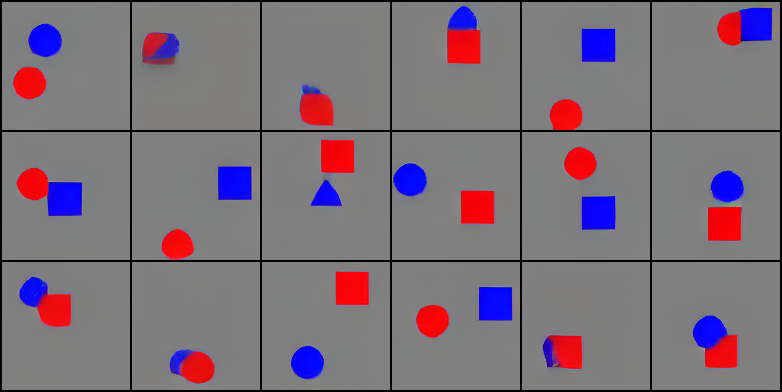

Epoch: 550, Step: 22000
Total number of transformer parameters: 31273376


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 550, Step: 22000


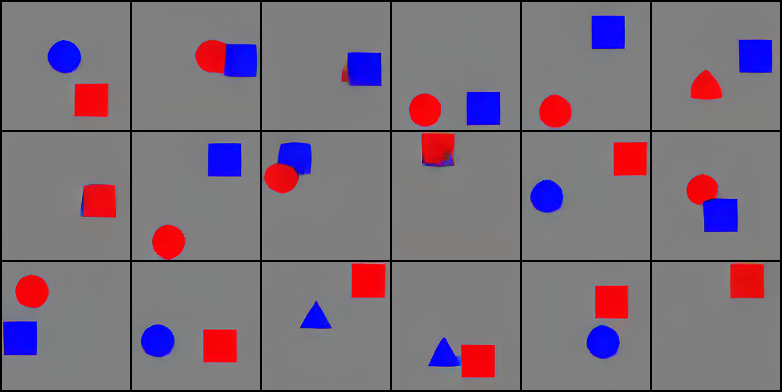

Epoch: 575, Step: 23000
Total number of transformer parameters: 31273376


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 575, Step: 23000


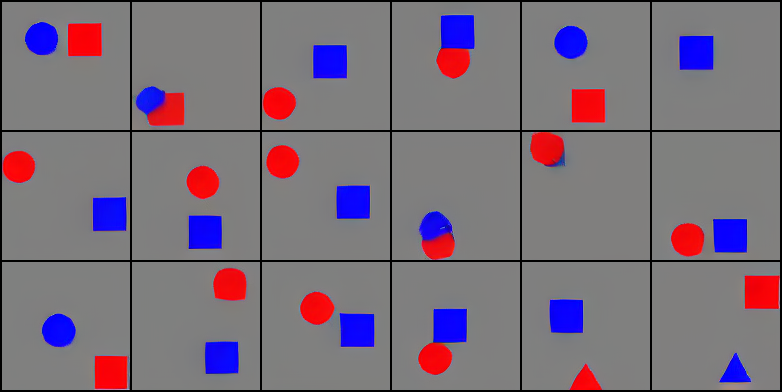

Epoch: 600, Step: 24000
Total number of transformer parameters: 31273376


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 600, Step: 24000


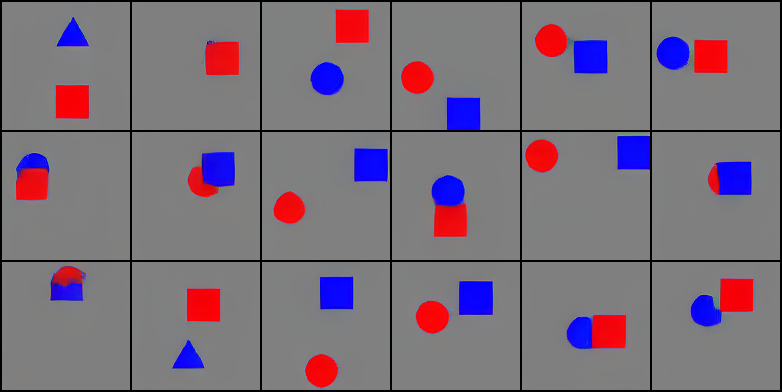

Epoch: 625, Step: 25000
Total number of transformer parameters: 31273376


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 625, Step: 25000


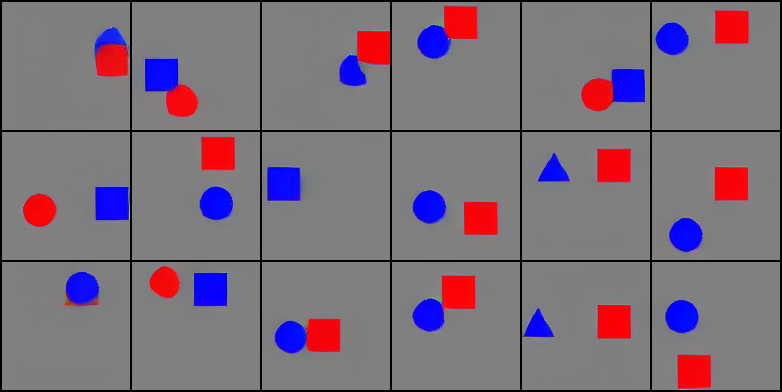

Epoch: 650, Step: 26000
Total number of transformer parameters: 31273376


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 650, Step: 26000


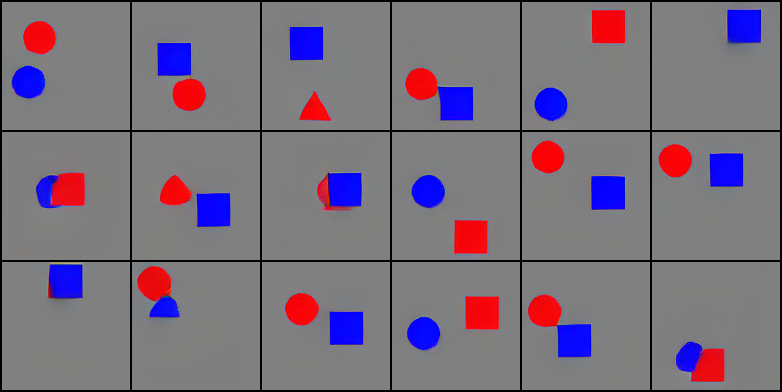

Epoch: 675, Step: 27000
Total number of transformer parameters: 31273376


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 675, Step: 27000


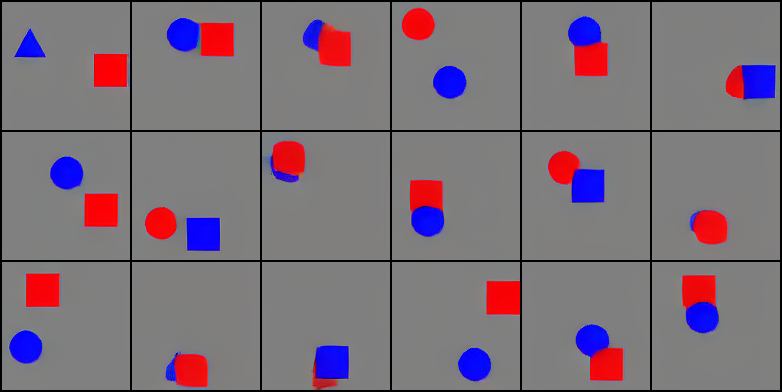

In [77]:
for ckpt_name in sorted_filenames:
    epoch, step = extract_epoch_step(ckpt_name)
    print(f"Epoch: {epoch}, Step: {step}")
    transformer = convert_checkpoint_to_diffusers_transformer(join(ckpt_root, ckpt_name) , None, "DiT_S-2", 128,)
    pipe.transformer = transformer.half().cuda()
    prompt = "red circle on the left of blue square"
    images = pipe(prompt=prompt, use_resolution_binning=False, 
              num_images_per_prompt=18, guidance_scale=1).images # height=128, width=128, 
    print(f"Epoch: {epoch}, Step: {step}")
    display(pil_images_to_grid(images, grid_size=(6, 3)))
# images[0]